# Self-driving car using Deep Learning

This project demonstrates the efficacy of deep neural network to self-drive cars inside a simulator based on human behaviour cloning approach. 

Our goal is to drive the car autonomously using the neural network trained on human driving behaviour. Udacity provided the simulator based on OpenAI's platform. It allows user to both collect the driving data by manually driving the car, and to drive automously using the python script ([drive.py](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/585b1df0_drive/drive.py)) that uses the predictions generated by the neural network for steering the car. Simulator provides two tracks. Driving data was collected from driving on track1 and the model was generalized to be able to drive on both the tracks. 




## Approach

I used the AWS GPU machines to train the neural net. Data was collected iteratively after many trials and error. Finally settled down on following datasets:

- Udacity provided data
- Data collected by driving three laps on Track 1 (forward only driving)
- Recovery data for the hard curves, multiple runs based on experiments

I did not use reverse track driving for the final model.

It was very hard to drive the car using keyboard and mouse, so ended by buying [Logitech Extreme 3D Pro](http://gaming.logitech.com/en-us/product/extreme-3d-pro-joystick) joystick for driving the car.

Both [Comma.ai (simpler streeing model)](https://github.com/commaai/research) and [Nvidia's end-to-end driving model](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) were explored, and ended up using the Nvidia model for the final solution. 



In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import shutil
import os
import random
import cv2
import math
import json

import keras
from keras.preprocessing.image import *
from keras.models import Sequential, Model
#from keras.layers import Convolution2D, Flatten, MaxPooling2D, Lambda, ELU, Conv2D
#from keras.layers.core import Dense, Dropout, Activation
#from keras.optimizers import Adam
from keras.callbacks import Callback, TensorBoard, ModelCheckpoint
import model   # Import our model from model.py

from IPython.display import display 

# Visualizations will be shown in the notebook.
%matplotlib inline

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

## Loading Dataset

Udacity data was used as baseline (it can be downloaded [here](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip))

Additional 3 laps of driving on track1 and recovery data were collected. 

Initially model was trained in stages (one dataset at a time adding on top of existing learnt weights from previous runs). After ariving at final solution, a clean integrated dataset was compiled for the full end to end training of the model. 


In [2]:

# Set this to True if using previous training model to add more training on top
load_prev_model = False

prev_model_w = './models/model-udata.h5'   # Used if load_prev_model is true - for the trained weights file
prev_model_m = './models/model-udata.json' # Used if load_prev_model is true - for loading the model
model_w = './models/model-all3.h5'  #output weights filename
model_m = './models/model-all3.json' #output model filename


# CSV file with all the image names and the corresponding steering angle, throttle, speed and brake data from the Car Simulator
data_csv = './data/driving_all_new2.csv'
img_path_prefix = './data/'


In [3]:
# Don't forget to add the colum header's. The Udacity simulator does not add these
columns = ['center', 'left', 'right', 'steering_angle', 'throttle', 'brake', 'speed']
data = pd.read_csv(data_csv, names=columns, header=0)

print("Dataset Columns:", columns, "\n")
print("Shape of the dataset:", data.shape, "\n")
print(data.describe(), "\n")

print("Data loaded...")
print(data.steering_angle[100])

Dataset Columns: ['center', 'left', 'right', 'steering_angle', 'throttle', 'brake', 'speed'] 

Shape of the dataset: (25892, 7) 

       steering_angle      throttle         brake         speed
count    25892.000000  25892.000000  25892.000000  2.589200e+04
mean        -0.007970      0.456022      0.009705  2.148344e+01
std          0.224380      0.399124      0.085415  9.332552e+00
min         -1.000000      0.000000      0.000000  5.177110e-07
25%         -0.044205      0.073169      0.000000  1.435149e+01
50%          0.000000      0.348322      0.000000  2.453909e+01
75%          0.000000      0.985533      0.000000  3.018296e+01
max          1.000000      1.000000      1.000000  3.070936e+01 

Data loaded...
-0.05975719


In [4]:
print(data.center[0])

udata/IMG/center_2016_12_01_13_30_48_287.jpg


## Exploring Dataset

Let us analyze the loaded dataset. 

Distribution of the steering angle is the key aspect to consider for generating good predictions. 

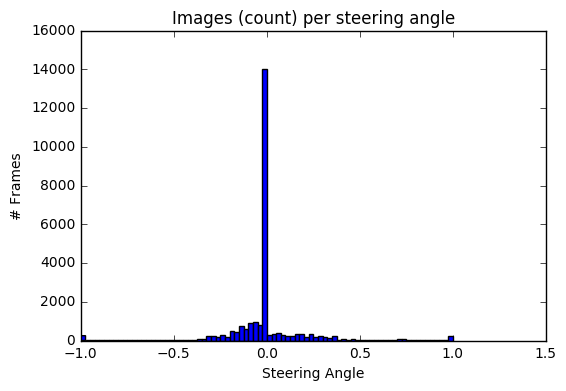

In [5]:
binwidth = 0.025

# histogram before image augmentation
plt.hist(data.steering_angle,bins=np.arange(min(data.steering_angle), max(data.steering_angle) + binwidth, binwidth))
#plt.hist(np.absolute(data.steering_angle),bins=np.arange(min(np.absolute(data.steering_angle)), max(np.absolute(data.steering_angle)) + binwidth, binwidth))
plt.title('Images (count) per steering angle')
plt.xlabel('Steering Angle')
plt.ylabel('# Frames')
plt.show()

As you can see above there is a veavy bias of streeing angle zero -- which corresponds to driving in straight direction. If we train our neural network simply on this data, it will not yield good predictions. 

Note that this dataset already includes the recovery data we recorded for the hard turns. We will have to use Data Augmentation techniques to create a more balanced dataset for training. 

Before we do the Data Augmentation, let's partition the data for training and validation. 

## Data Partitioning

Here we shuffle and split our dataset into two parts: Training data and Validation data. 90% data is kept for training and remaining 10% will be used for validation. 

There is no need to set aside any testing data, as the testing will be done by driving on the actual simulator track.

In [6]:
# Get randomized datasets for training and validation

# shuffle data
data = data.reindex(np.random.permutation(data.index))

num_train = int((len(data) / 10.) * 9.)

X_train = data.iloc[:num_train]
X_validation = data.iloc[num_train:]

print("X_train has {} elements.".format(len(X_train)))
print("X_valid has {} elements.".format(len(X_validation)))


X_train has 23302 elements.
X_valid has 2590 elements.


In [7]:
print(X_train.right[3])

# Some of the image file names have extra spaces, remember to strip these before loading the file
path_file = img_path_prefix + X_train.right[3].strip()
print (path_file)
img = cv2.imread(path_file)
print(img.shape)
#cv2.imshow(path_file, img)

 udata/IMG/right_2016_12_01_13_31_13_037.jpg
./data/udata/IMG/right_2016_12_01_13_31_13_037.jpg
(160, 320, 3)


## Configurable Variables

These are all the configurable variables in our program:

In [8]:
# image augmentation variables
CAMERA_OFFSET = 0.25
WIDTH_SHIFT_RANGE = 100
HEIGHT_SHIFT_RANGE = 40

# processed image variables
PROCESSED_IMG_ROWS = 66 
PROCESSED_IMG_COLS = 200 
PROCESSED_IMG_CHANNELS = 3

# model training variables
NB_EPOCH = 8 #8
NUM_GPUS = 1  # Not used
BATCH_SIZE = 256*NUM_GPUS

- *CAMERA_OFFSET:* The simulator car uses three cameras - left, right and center. Steering angle in the data corresponds to the center camera. Camera offet will be used to data augmentation to use the left and right camera images for recovery training.  A small angle .25 will be added to the left camera and similarly a small angle of 0.25 will be subtracted from the right camera, to normalize the images for training.

- *WIDTH_SHIFT_RANGE:* Input images are randomly width shifted in range [-100, 100] -- Shifting the input image horizontally by a small fraction is another technique in image augmentation. 

- *HEIGHT_SHIFT_RANGE:* Similarly input image are shifted vertically by a small fraction, in the range [-40, 40]

- *PROCESSED_IMG_COLS:* Final step in our image augmentation process is Croping and Resizing. Image size of 66x200 was used as in the NVidia paper. Hence height of the processed image will be 66px.

- *PROCESSED_IMG_ROWS:* Width of the processed image will be 200px.

- *PROCESSED_IMG_CHANNELS:* We will use all three color channels as in the Nvidia paper

- *NB_EPOCH:* After multiple trials a epochs size of 8 was selected for best results. 

- *BATCH_SIZE:* After multiple trails, a batch size of 256 was selected for training the model. This keeps the memory footprint manageable and yields good results over the epochs selected. 

## Image Augmentation 

As noted earlier, we will generate new training data from a smaller dataset for under represented steering angles by a technique called Image Augmentation.

We will use following 7 augmentation functions in our image processing pipeline:

- horizontal_flip
- random shadow
- height_shift
- width_shift
- brightness_shift
- crop_image
- resize_image

In [9]:
# flip images horizontally
def horizontal_flip(img, steering_angle):
    flipped_image = cv2.flip(img, 1)
    steering_angle = -1 * steering_angle
    return flipped_image, steering_angle

This function flips the input image horizontally using OpenCV apis. In doing so it appropriately reverses the sign of the steering angle to reflect the transformation.

In [10]:
# Add random shadow in vertical slice of image
def random_shadow(img):
    changed_img = img
    h, w = changed_img.shape[0], changed_img.shape[1]
    [x1, x2] = np.random.choice(w, 2, replace=False)
    k = h / (x2 - x1)
    b = - k * x1
    for i in range(h):
        c = int((i - b) / k)
        changed_img[i, :c, :] = (changed_img[i, :c, :] * .5).astype(np.int32)
    return changed_img


One of the tricks in augmenting an image is to shift its color channel by a small fraction. This function randomly shifts input image channel in the range [-0.2, 0.2] by using keras image processing apis. Steering angle does not change after this transformation.

In [11]:
# shift height/width of the image by a small fraction
def height_width_shift(img, steering_angle):
    rows, cols, channels = img.shape
    
    # Translation
    tx = WIDTH_SHIFT_RANGE * np.random.uniform() - WIDTH_SHIFT_RANGE / 2
    ty = HEIGHT_SHIFT_RANGE * np.random.uniform() - HEIGHT_SHIFT_RANGE / 2
    steering_angle = steering_angle + tx / WIDTH_SHIFT_RANGE * 2 * .2
    
    transform_matrix = np.float32([[1, 0, tx],
                                   [0, 1, ty]])
    
    translated_image = cv2.warpAffine(img, transform_matrix, (cols, rows))
    return translated_image, steering_angle

Shifting the input image horizontally and vertically by a small fraction is another technique in image augmentation. This function randomly shifts images both vertically and horizontally in the given range by using OpenCV apis. A new steering angle is also calculated to match the transformation.

In [12]:
def brightness_shift(img, bright_value=None):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    if bright_value:
        img[:,:,2] += bright_value
    else:
        random_bright = .25 + np.random.uniform()
        img[:,:,2] = img[:,:,2] * random_bright
    
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img

This function randomly changes the brightness (or darkness) of the input image using OpenCV apis. Steering angle does not change after this transformation.

In [13]:
# crop the top 1/5 of the image to remove the horizon and the bottom 25 pixels to remove the car’s hood
import scipy.misc

def center_crop(x, crop_h, crop_w=None, resize_w=64):
    if crop_w is None:
        crop_w = crop_h
    h, w = x.shape[:2]
    j = int(round((h - crop_h)/2.))
    i = int(round((w - crop_w)/2.))
    return scipy.misc.imresize(x[j:j+crop_h, i:i+crop_w],
                               [resize_w, resize_w])

def transform(image, npx=64, is_crop=True):
    # npx : # of pixels width/height of image
    if is_crop:
        cropped_image = center_crop(image, npx)
    else:
        cropped_image = image
    return np.array(cropped_image)/127.5 - 1.

def center_crop_resize_image(img):
    shape = img.shape
    img = img[math.floor(shape[0]/5):shape[0]-25, 0:shape[1]]
    #img = cv2.resize(img, (PROCESSED_IMG_COLS, PROCESSED_IMG_ROWS), interpolation=cv2.INTER_AREA)  
    img = center_crop(img, PROCESSED_IMG_COLS, PROCESSED_IMG_ROWS)
    return img

def crop_resize_image(img):
    shape = img.shape
    img = img[math.floor(shape[0]/5):shape[0]-25, 0:shape[1]]
    img = cv2.resize(img, (PROCESSED_IMG_COLS, PROCESSED_IMG_ROWS), interpolation=cv2.INTER_AREA)  
    return img

This function will crop the top 1/5 of the image to remove the horizon and the bottom 25 pixels to remove the car’s hood. Steering angle does not change after this transformation.

In [14]:
def apply_random_transformation(img, steering_angle):
     
    transformed_image = img
    transformed_image, steering_angle = height_width_shift(transformed_image, steering_angle)
    if np.random.random() < 0.5:
        transformed_image = random_shadow(transformed_image)
    if np.random.random() < 0.5:
        transformed_image = brightness_shift(transformed_image)
    
    if np.random.random() < 0.5:
        transformed_image, steering_angle = horizontal_flip(transformed_image, steering_angle)
            
    transformed_image = crop_resize_image(transformed_image)
    
    # Color change to HSV where it is easier to recognize the road in the track
    transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_RGB2HSV)
        
    return transformed_image, steering_angle

This is the wrapper function which makes use of all the previous transformations to augment an image. This function is directly used in the image generator.



## Image Augmentation 

Let us now see all the image transformation functions in action. Here we take an image and apply all the transformations to it. The ouput of the transformation is plotted below. 

At the bottom of each transformed image, we have noted the name of the transformation function and corresponding steering angle change (if any).

Following augmentations will be performed on the images:

1. Height and width shifting
2. Random shadow (this was added to improve performance of the car driving on second track which has more shadows)
3. Random Brightness shift
4. Random horizontal flip
5. Cropping and resizing
6. Convert to HSV color space -- which makes it easier to recongnize the road

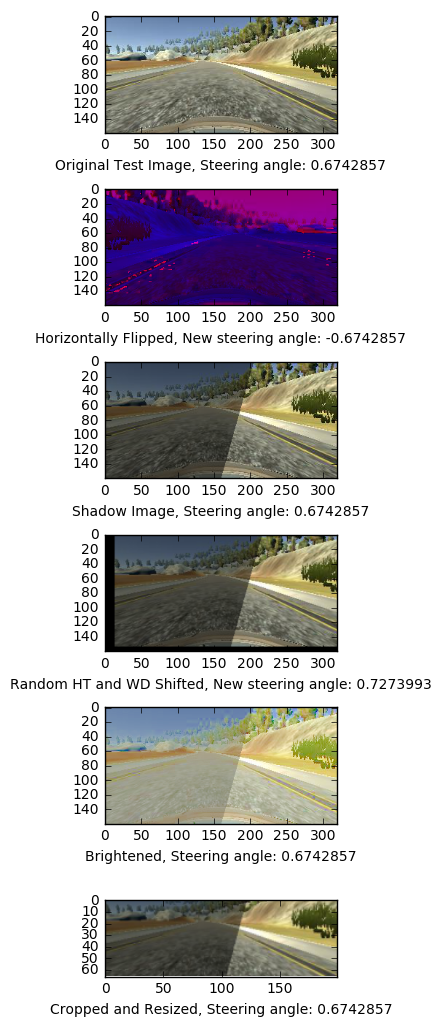

In [15]:
def read_image(fn):
    img = load_img(fn)
    img = img_to_array(img) 
    return img

test_fn = "./data/train1/IMG/center_2017_03_22_23_24_48_084.jpg"
steering_angle = 0.6742857

test_image = read_image(test_fn)

plt.subplots(figsize=(3, 13))

# original image
plt.subplot(611)
plt.xlabel("Original Test Image, Steering angle: " + str(steering_angle))
plt.imshow(array_to_img(test_image))

# horizontal flip augmentation
flipped_image, new_steering_angle = horizontal_flip(cv2.cvtColor(test_image, cv2.COLOR_RGB2HSV), steering_angle)
plt.subplot(612)
plt.xlabel("Horizontally Flipped, New steering angle: " + str(new_steering_angle))
plt.imshow(array_to_img(flipped_image))

# random shadow  augmentation
random_shadow_image = random_shadow(test_image)
plt.subplot(613)
plt.xlabel("Shadow Image, Steering angle: " + str(steering_angle))
plt.imshow(array_to_img(random_shadow_image))

# width shift augmentation
width_shifted_image, new_steering_angle = height_width_shift(test_image, steering_angle)
new_steering_angle = "{:.7f}".format(new_steering_angle)
plt.subplot(614)
plt.xlabel("Random HT and WD Shifted, New steering angle: " + str(new_steering_angle))
plt.imshow(array_to_img(width_shifted_image))

# brightened image
brightened_image = brightness_shift(test_image, 255)
plt.subplot(615)
plt.xlabel("Brightened, Steering angle: " + str(steering_angle))
plt.imshow(array_to_img(brightened_image))


# crop augmentation
cropped_image = crop_resize_image(test_image)
plt.subplot(616)
plt.xlabel("Cropped and Resized, Steering angle: " + str(steering_angle))
_ = plt.imshow(array_to_img(cropped_image))

## Keras generator for subsampling

As there was limited data and we are generating thousands of training examples from the same image, it is not possible to store all the images into memory. We will utilize kera’s generator function to sample images such that images with lower angles have lower probability of getting represented in the dataset. This alleviates any problems we may ecounter due to model having a bias towards driving straight. 

Given a line from csv file, this function randomly loads center or left or right image. Applies all appropriate image augmentation functions to it and return augmented image and transformed steering angle. This function is directly used in Keras generator function below.

In [16]:
def load_and_augment_image(line_data):
    i = np.random.randint(3)
    
    if (i == 0):
        path_file = line_data['left'][0].strip()
        shift_angle = CAMERA_OFFSET
    elif (i == 1):
        path_file = line_data['center'][0].strip()
        shift_angle = 0.
    elif (i == 2):
        path_file = line_data['right'][0].strip()
        shift_angle = -CAMERA_OFFSET
        
    steering_angle = line_data['steering_angle'][0] + shift_angle
    
    #print(path_file)
    img = cv2.imread(img_path_prefix + path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img, steering_angle = apply_random_transformation(img, steering_angle)
    return img, steering_angle

In [17]:
#x, y = load_and_augment_image(X_train.iloc[[10]].reset_index())
                
path_file = './data/train1/IMG/center_2017_03_22_23_37_52_398.jpg'
img = cv2.imread(path_file)
#print(img)
#cv2.imshow(path_file, img)

It turns out that Keras generator, actually any python generator, is **not thread-safe** in multi-threaded application. Solution is to wrap our iterator/generator in a thread safe class such as one below. You can read about python iterator/generator thread safety [here](http://anandology.com/blog/using-iterators-and-generators/)


https://github.com/fchollet/keras/issues/1638  provides full example



In [18]:
# generators in multi-threaded applications is not thread-safe. Hence below:
class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self
    
    def __next__(self):
        with self.lock:
            return self.it.__next__()
        
def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

A keras image generator is used for feeding into the model. It generates batches of augmented images on-the-fly from the dataset that Udacity provided. You can get more intutiton about Keras generators [here](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

The ‘threshold’ variable is a threshold that determines if a data with small angle will be dropped or not.

In [19]:
generated_steering_angles = []
threshold = 1

@threadsafe_generator
def generate_batch_data(_data, batch_size = 32):
    
    batch_images = np.zeros((batch_size, PROCESSED_IMG_ROWS, PROCESSED_IMG_COLS, PROCESSED_IMG_CHANNELS))
    batch_steering = np.zeros(batch_size)
    
    while True:
        for batch_index in range(batch_size):
            row_index = np.random.randint(len(_data))
            line_data = _data.iloc[[row_index]].reset_index()
            
            # idea borrowed from Vivek Yadav: Sample images such that images with lower angles 
            # have lower probability of getting represented in the dataset. This alleviates 
            # any problems we may ecounter due to model having a bias towards driving straight.
            
            keep = 0
            while keep == 0:
                x, y = load_and_augment_image(line_data)
                if abs(y) < .1:
                    val = np.random.uniform()
                    if val > threshold:
                        keep = 1
                else:
                    keep = 1
            
            batch_images[batch_index] = x
            batch_steering[batch_index] = y
            generated_steering_angles.append(y)
        yield batch_images, batch_steering

## Examples of generated images

Now let us look at few augmented images generated by our image processing pipeline.

Quite evidently you will notice that all processed images have 'road' clearly visible and is front and center. These images will be fed to a Deep Neural Network as training images. Just by looking at the quality of these images, we have good confidence that our Network will train well. 


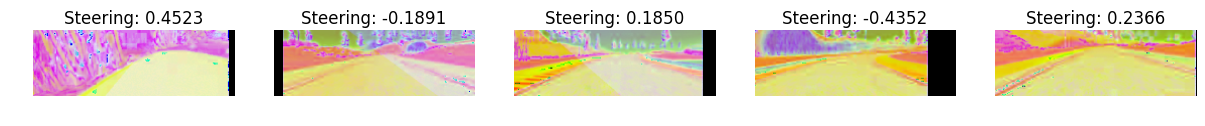

In [20]:
iterator = generate_batch_data(X_train, batch_size=5)
sample_images, sample_steerings = iterator.__next__()

#print(sample_images)

plt.subplots(figsize=(15, 2))
for i, img in enumerate(sample_images):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.title("Steering: {:.4f}".format(sample_steerings[i]))
    plt.imshow(img)
plt.show()

## Model Architecture and training

Multiple training architectures based on Convolutional Neural Networks were evaluated. Most of them failed. Many had partial success. Collecting the right data for model tuning was one of the challenges. Transfer learning with VGG16 was attempted after removing the final layers and replacing them with fully connected and convolutional layers. However it did not give good results on track2. 

Further experiments were done with the [nVIDIA model](http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf) and [comma.ai](https://github.com/commaai/research/blob/master/train_steering_model.py) model (the simpler train steering model). After many trials and errors ended up selecting the Nvidia model. 

Here is a summary of the network:

- A normalization layer on the top of the network to normalize the input images.
- Convolutional layer, 24 feature maps with a size of 5×5 and stride 2x2, an Exponential Linear Unit(elu) activation function with he_norm initializer (used same initializer for all layers).
- Convolutional layer, 36 feature maps with a size of 5×5, stride 2x2, an elu activation, he_norm initializer.
- Convolutional layer, 48 feature maps with a size of 5×5, stride 2x2, an elu activation, he_norm initializer.
- Convolutional layers, 64 feature maps with a size of 3×3, stride 1x1, an elu activation, he_norm initializer.
- Convolutional layers, 64 feature maps with a size of 3×3, stride 1x1, an elu activation, he_norm initializer.
- Flatten layer.
- Fully connected layer with 1164 units, elu activation, he_norm initializer.
- Fully connected layer with 100 units, elu activation, he_norm initializer.
- Fully connected layer with 50 units, elu activation, he_norm initializer.
- Fully connected layer with 10 units, elu activation, he_norm initializer.
- Fully connected output layer with 1 unit and no activation function as this is a regression problem, not classification.

No dropouts were used.

A 'mean_squared_error' loss function is used with Adam optimization algorithm configured with a learning rate of 0.0001. This learning rate was selected after bit of trial and error. With larger learning rates (0.1 and 0.001), car was making abrupt steering angle changes, causing bumpy ride.


### Training Strategy

The dataset obtained from Udacity consisted of image files and a CSV file. The CSV file was loaded into a pandas dataframe, shuffled and then split into Training data and Validation data. 

An image generator that takes the pandas dataframe as input and generates batches of training data is developed. This can be seen in the 'generate_batch_data' method in the notebook. The dataset was augmented by also using the right and left camera images with a 0.25 degree shift to the original steering angle. The input images were augmented with various techniques such as Horizontal-Flip, Height-Width shift, Color-channel shift, Brightness shift etc. Images were then cropped out. The region of interest starts under the horizon, removes most of the exterior environment and focuses on the road. This is similar to what was done in the NVIDIA model. The image was then resized to 64 × 64 before being passed into the model.

The ADAM optimizer with a learning rate of 0.0001 is used. The data is trained over 8 epochs of ~20000 samples each.


Note: With keras 2.0 model save load getting error http://stackoverflow.com/questions/42888030/unboundlocalerror-local-variable-class-name-referenced-before-assignment As workaround had to reload the model definition in the drive.py each time and only the weights from saved model could be reused. 


In [21]:
# See model.py for actual model code  
nmodel = model.build_model(PROCESSED_IMG_ROWS, PROCESSED_IMG_COLS, PROCESSED_IMG_CHANNELS)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 31, 98, 24)        1824      
_________________________________________________________________
Conv2 (Conv2D)               (None, 14, 47, 36)        21636     
_________________________________________________________________
Conv3 (Conv2D)               (None, 5, 22, 48)         43248     
_________________________________________________________________
Conv4 (Conv2D)               (None, 3, 20, 64)         27712     
_________________________________________________________________
Conv5 (Conv2D)               (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
__________

## Model Visualization

Keras visualization utility provides a good pictorial representation of our model. 

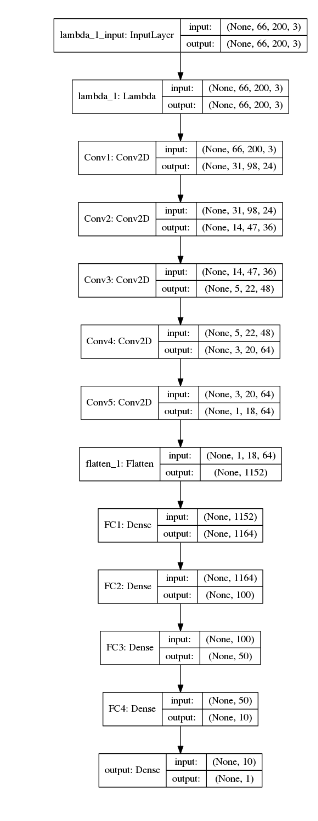

In [22]:
import pydot_ng as pydot
from keras.utils import plot_model

plot_model(nmodel, to_file='model.png', show_shapes=True)

img = read_image('model.png')

# # original image
plt.subplots(figsize=(5,10))
plt.subplot(111)
plt.axis('off')
plt.imshow(array_to_img(img))

## Model Fitting

One of the key strategies of this solution is to - sample images such that images with lower angles have lower probability of getting represented in the dataset. This alleviates any problems we may ecounter due to model having a bias towards driving straight. The ‘threshold’ variable is a threshold that determines if a data with small angle will be dropped or not. Its value should be progressively reduced as model training continues, so that small amount of lower steering angles are also learned by the model. The value of 'threshold' is reduced in the 'on_epoch_end' callback as shown below. 

In [23]:
class LifecycleCallback(keras.callbacks.Callback):

    def on_epoch_begin(self, epoch, logs={}):
        pass

    def on_epoch_end(self, epoch, logs={}):
        global threshold
        threshold = 1 / (epoch + 1)

    def on_batch_begin(self, batch, logs={}):
        pass

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

    def on_train_begin(self, logs={}):
        print('BEGIN TRAINING')
        self.losses = []

    def on_train_end(self, logs={}):
        print('END TRAINING')
        
# Calculate the correct number of samples per epoch based on batch size
def calc_samples_per_epoch(array_size, batch_size):
    num_batches = array_size / batch_size
    samples_per_epoch = math.ceil(num_batches)
    samples_per_epoch = samples_per_epoch * batch_size
    return samples_per_epoch

### Start training the model

If the load_prev_model flag is set, the weights from previous model train run are loaded and model is further trained on top. 

In [24]:
if load_prev_model:
    # load json and create model
    json_file = open(prev_model_m, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    #model = model_from_json(loaded_model_json)


    # load weights into new model
    nmodel.load_weights(prev_model_w)
    print("Loaded model from disk")
    

In [25]:
lifecycle_callback = LifecycleCallback()       
modelchkpt_callback = ModelCheckpoint('./models/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=True, mode='auto', period=1)

train_generator = generate_batch_data(X_train, BATCH_SIZE)
validation_generator = generate_batch_data(X_validation, BATCH_SIZE)

#samples_per_epoch = calc_samples_per_epoch((len(X_train)*3), BATCH_SIZE)
steps_per_epoch = np.round((len(X_train)*3)/BATCH_SIZE)
validation_steps= np.round((len(X_validation)*3)/BATCH_SIZE)
#nb_val_samples = calc_samples_per_epoch((len(X_validation)*3), BATCH_SIZE)
print("steps per epoch {}".format(steps_per_epoch))
print("val steps  {}".format(validation_steps))

history = nmodel.fit_generator(train_generator, 
                              validation_data = validation_generator,
                              validation_steps = validation_steps,
                              steps_per_epoch = steps_per_epoch, 
                              epochs = NB_EPOCH, verbose=1,
                              callbacks=[modelchkpt_callback, lifecycle_callback])

steps per epoch 273.0
val steps  30.0
BEGIN TRAINING
Epoch 1/8
273/273 [==============================] - 1014s - loss: 0.0978 - val_loss: 0.0769
Epoch 2/8
273/273 [==============================] - 446s - loss: 0.0755 - val_loss: 0.0721
Epoch 3/8
273/273 [==============================] - 382s - loss: 0.0721 - val_loss: 0.0686
Epoch 4/8
273/273 [==============================] - 370s - loss: 0.0692 - val_loss: 0.0650
Epoch 5/8
273/273 [==============================] - 365s - loss: 0.0672 - val_loss: 0.0665
Epoch 6/8
273/273 [==============================] - 359s - loss: 0.0640 - val_loss: 0.0632
Epoch 7/8
273/273 [==============================] - 357s - loss: 0.0627 - val_loss: 0.0613
Epoch 8/8
273/273 [==============================] - 358s - loss: 0.0616 - val_loss: 0.0607
END TRAINING



## Save Model

In [26]:
model_json = nmodel.to_json()
with open(model_m, "w") as json_file:
    json.dump(model_json, json_file)
nmodel.save_weights(model_w)
print("Saved model + weights to disk: " + model_w)

Saved model + weights to disk: ./models/model-all3.h5


## Analysis

The histogram of "steering angles" at the begining of the project showed that there were too many samples with 0.0 angle. We noted then that, in order to teach our car to take turns, we need  to generate many new images with non-zero angles by augmentation. 

Let's look at the generated images histogram to see what type of images and steering angle the model was trained on. 

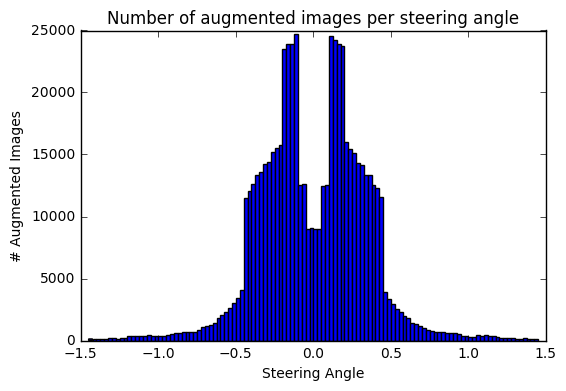

In [27]:
plt.hist(generated_steering_angles, bins=np.arange(min(generated_steering_angles), max(generated_steering_angles) + binwidth, binwidth))
plt.title('Number of augmented images per steering angle')
plt.xlabel('Steering Angle')
plt.ylabel('# Augmented Images')
plt.show()

Bingo! The number of augmented images for non-zero steering angles are far more than for 0.0 angle. With this training data, our car is bound to not only learn to drive straight but also to drive curves and turns.

## Plots

Let us now look at 'model loss' plot. 

dict_keys(['loss', 'val_loss'])


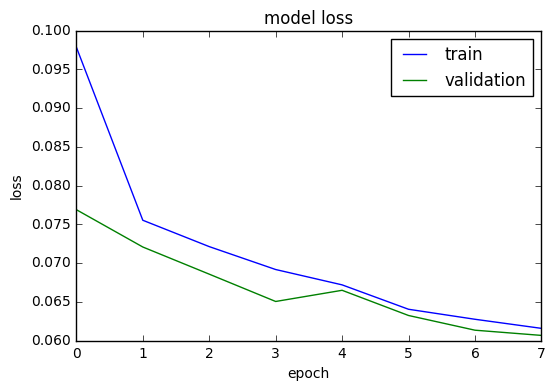

In [28]:
# list all data in history
from keras.callbacks import History

print(history.history.keys())

# summarize history for epoch loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

As seen in the above plot, both Training and Validation Loss systematically dropped our 8 training epochs. This is a clear sign that our model has NOT overfitted the data and has generalized well. Hopefully it will work well for new and unseen data (new driving track in our project).

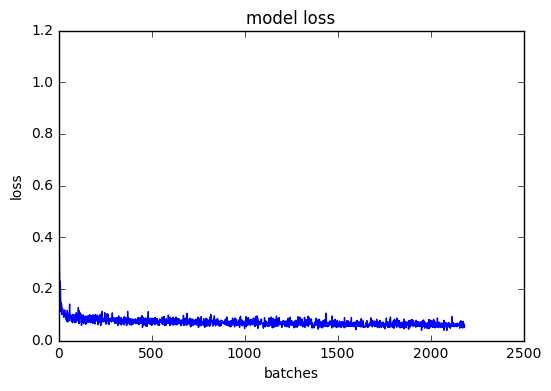

In [29]:
# summarize history for batch loss
batch_history = lifecycle_callback.losses
plt.plot(batch_history)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('batches')
plt.show()

Similarly, as seen in the above plot, model's cost decreased as the training progessed, indicating that model improved with more training data.

## Some layer visualizations

Let's look at the feature maps of the Neural network to get an understanding of how it learns to drive. 

In [42]:
# Layer visualizations

test_fn = "./data/train1/IMG/center_2017_03_22_23_24_48_084.jpg"

def visualize_model_layer_output(layer_name):
    model2 = Model(input=nmodel.input, output=nmodel.get_layer(layer_name).output)

    img = load_img(test_fn)
    img = crop_resize_image(img_to_array(img))
    img = np.expand_dims(img, axis=0)

    conv_features = model2.predict(img)
    print("conv features shape: ", conv_features.shape)
    
    # plot features
    plt.subplots(figsize=(15, 5))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.axis('off')
        plt.imshow(conv_features[0,:,:,i], cmap='gray')
    plt.show()

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("Co..., inputs=Tensor("la...)`


conv features shape:  (1, 31, 98, 24)


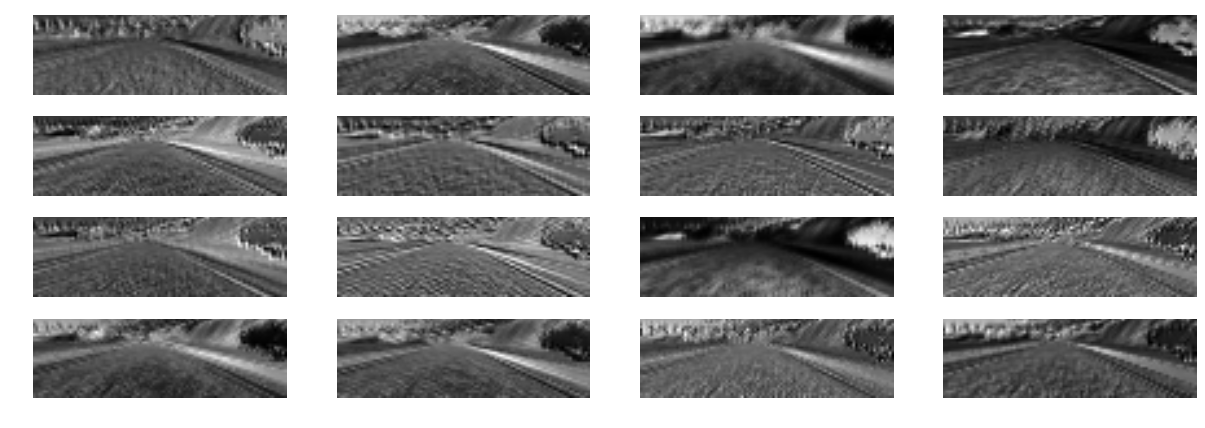

In [43]:
visualize_model_layer_output('Conv1')

These are some of the feature map plots after first convolution layer. As you can see model has detected simple features such as edges and straight lines at this point. You can actually see the road ahead in all the feature map.

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("Co..., inputs=Tensor("la...)`


conv features shape:  (1, 14, 47, 36)


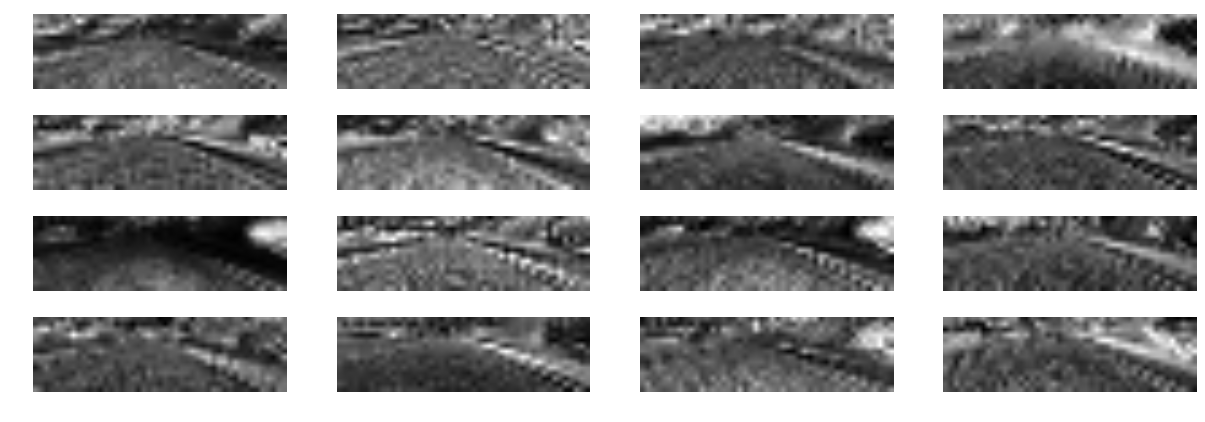

In [44]:
visualize_model_layer_output('Conv2')

These are feature map plots after second convolution layer. These features are higher level feature learnt from previous layer's output. At this point it is hard to decipher what Neural Network is doing.

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("Co..., inputs=Tensor("la...)`


conv features shape:  (1, 5, 22, 48)


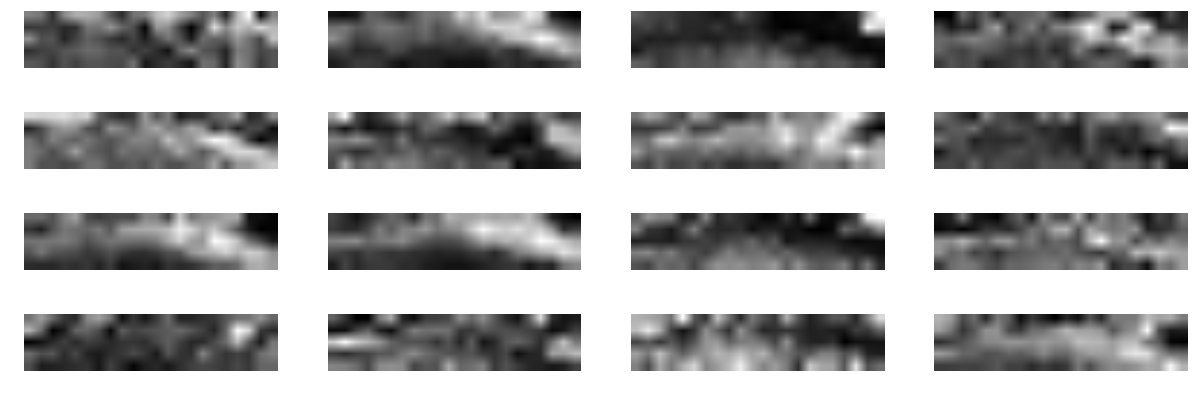

In [45]:
visualize_model_layer_output('Conv3')

## The Final Test

The best test for the model is to actually let the car drive autonomously on both Training and Test (unseen) tracks. Let us see how our model did in these recorded videos.

### Track 1

All the hard work of collectimg data from hard turns and extensive testing of the model finally payed off. The car is driving successfully on track 1 staying within the road lines. Kept running for more than two tracks. 

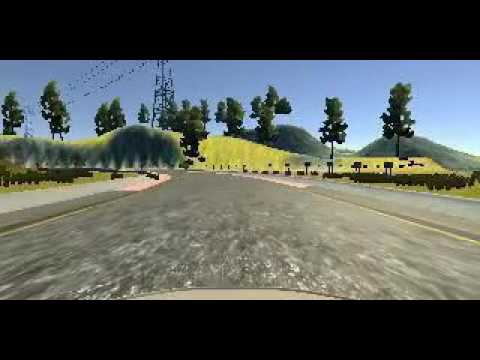

In [46]:
from IPython.display import YouTubeVideo
YouTubeVideo('4SNuhUKTq-w')

### Track 2

It was very exciting to see the car drive on second more complex track (without any training data from this track). The car drove for almost two laps. 

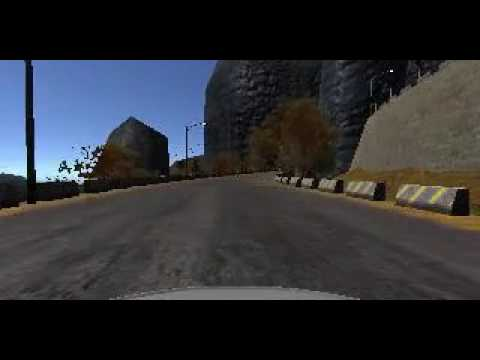

In [47]:
YouTubeVideo('noXURuNj2K0')

## Future Explorations

There is much room for improving the model. For future explorations I plan to try:
    
    1. Parallelizing the model / data for faster training on multi-GPU machines on AWS
    2. Comma.ai's auto-encoder based temporal model -- I am hoping this will allow to run the car on the Jungle gym track.
    3. Automate the pipeline for search based hyper parameter tunning, to run on distributed tensorflow
    4. Model serving with Tensorflow serving to see how to incorporate an online model with self learning
    5. Create a smaller optimized version of the model to run on Raspberry pi for my model car that I recently assembled for SCND